<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [ ]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [ ]:
# Google Drive connection

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Explore our Data & Preprocess

In [ ]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train')
test_folder = os.path.join(data_path, 'test')
val_folder = os.path.join(data_path, 'val')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

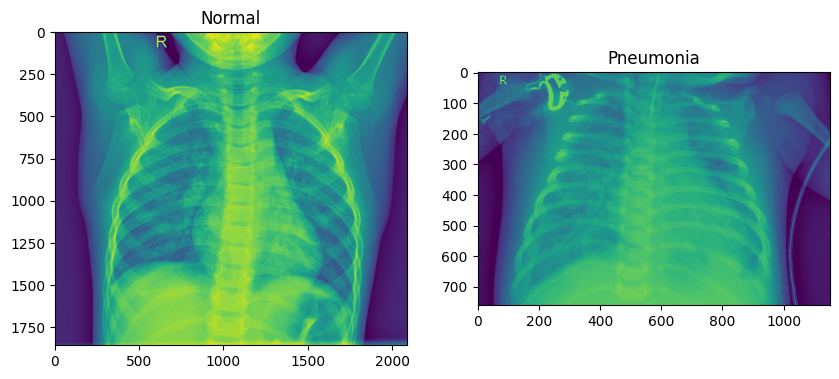

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [ ]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1342 normal images in the training set
There are 3876 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 9 normal images in the validation set
There are 9 pneumonia images in the validation set


Lets preprocess the images by resizing to (128, 128, 3)

In [ ]:
# Preprocess our Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path for data folders
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Set the input size for images
img_size = (128, 128)

# Set up data generators for training, testing, and validation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=300,
    class_mode='binary'  # Use 'categorical' if you have more than two classes
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=100,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=4,
    class_mode='binary'
)

# Optionally, check the class indices assigned by Keras
print("Class indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
# Retrieve one batch of images from the generator
images, labels = train_generator.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first image
plt.imshow(images[0])
plt.title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")
plt.show()

KeyboardInterrupt: ignored

We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

In [ ]:
# # Create the data sets with resized images
# def generate_data_sets(train_generator, test_generator, val_generator):

#     # Define batches from generators
#     train_batches = train_generator
#     test_batches = test_generator
#     val_batches = val_generator

#     # Create Train Set
#     X_train, y_train = [], []
#     for batch in train_batches:
#         # get the images from train gen
#         X_train.append(batch[0])
#         # get the labels from train gen
#         y_train.append(batch[1])

#     # Concatenate batches along the first axis
#     X_train = np.concatenate(X_train)
#     y_train = np.concatenate(y_train)

#     # Create the test set
#     X_test, y_test = [], []
#     for batch in test_batches:
#         # get the images from test gen
#         X_test.append(batch[0])
#         # get the labels from test gen
#         y_test.append(batch[1])

#     # Concatenate batches along the first axis
#     X_test = np.concatenate(X_test)
#     y_test = np.concatenate(y_test)

#     # Create the val set
#     X_val, y_val = [], []
#     for batch in val_batches:
#         # get the images from val gen
#         X_val.append(batch[0])
#         # get the labels from val gen
#         y_val.append(batch[1])

#     # Concatenate batches along the first axis
#     X_val = np.concatenate(X_val)
#     y_val = np.concatenate(y_val)

#     return X_train, X_test, X_val, y_train, y_test, y_val


In [ ]:
# # Generate data sets
# X_train, X_test, X_val, y_train, y_test, y_val = generate_data_sets(train_generator, test_generator, val_generator)

# # Print the shapes of the obtained sets
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)

In [ ]:
# create the temporary data sets to view shapes
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 300
Number of testing samples: 100
Number of validation samples: 4
train_images shape: (300, 128, 128, 3)
train_labels shape: (300,)
test_images shape: (100, 128, 128, 3)
test_labels shape: (100,)
val_images shape: (4, 128, 128, 3)
val_labels shape: (4,)


# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [ ]:
import time
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Initialize an empty DataFrame to hold epoch information
epoch_data_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'])

# Define the model outside the loop
model_mlp_base = Sequential()
model_mlp_base.add(Flatten(input_shape=(128, 128, 3)))
model_mlp_base.add(Dense(128, activation='relu'))
model_mlp_base.add(Dense(1, activation='sigmoid'))
model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def train_model_and_get_epoch_data(model, train_generator, val_generator, total_epochs=20):
    # Initialize an empty DataFrame to hold epoch information
    epoch_data_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy', 'Train Time'])

    # Record the start time for training all epoch range
    start_time = time.time()

    for epoch in range(1, total_epochs+1):
        # Record the start time for the current epoch
        epoch_start_time = time.time()

        # Train the model for set epochs
        history = model.fit(train_generator, epochs=epoch, validation_data=val_generator)

        # Record the end time for the current epoch
        epoch_end_time = time.time()

        # Calculate and print the time taken for the current epoch
        epoch_time_taken = epoch_end_time - epoch_start_time

        # Define history metrics
        train_loss = history.history['loss'][0]
        val_loss = history.history['val_loss'][0]
        train_acc = history.history['accuracy'][0]
        val_acc = history.history['val_accuracy'][0]

        # Append data to the DataFrame
        epoch_data_df = epoch_data_df.append({
            'Epoch': epoch,
            'Train Loss': train_loss,
            'Validation Loss': val_loss,
            'Train Accuracy': train_acc,
            'Validation Accuracy': val_acc,
            'Train Time': epoch_time_taken
        }, ignore_index=True)

        # Print the epoch information
        print(f"Epoch {epoch}: Time taken {epoch_time_taken} seconds")

    # Record the end time for training all epoch range
    end_time = time.time()

    # Print the total training time
    total_training_time = end_time - start_time
    print(f"Total training time: {total_training_time} seconds")

    # Return the DataFrame with epoch information
    return epoch_data_df

In [ ]:
train_data = train_model_and_get_epoch_data(custom_model, train_generator, val_generator, total_epochs=20)
print(train_data)

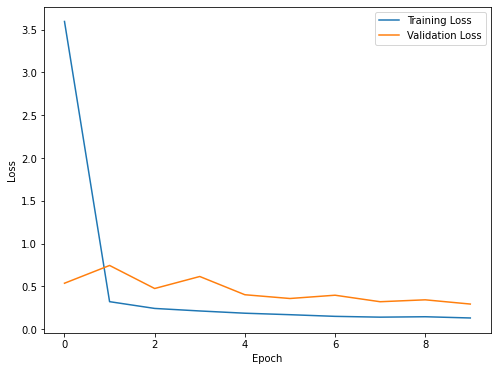

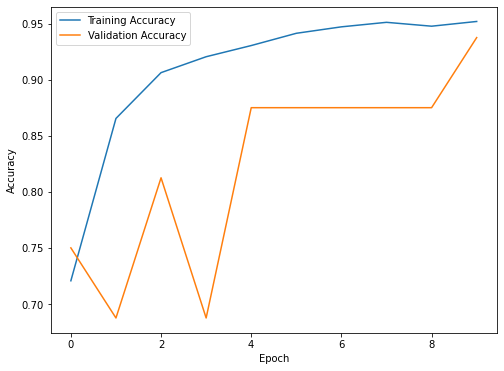

In [ ]:
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# # Load the training history
# loaded_history = np.load('training_history_base.npy', allow_pickle=True).item()

# # Plot the training loss and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(loaded_history['loss'], label='Training Loss')
# plt.plot(loaded_history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot the training accuracy and validation accuracy
# plt.figure(figsize=(8, 6))
# plt.plot(loaded_history['accuracy'], label='Training Accuracy')
# plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

It does not seem we have started overfitting yet as both the validation and training loss are still getting lower as training goes.